In [6]:
import matplotlib.pyplot as plt
import numpy as np
import wfdb
from keras.saving import load_model
from os import path
from librosa.feature import mfcc
import librosa
import sklearn.preprocessing as prep
from librosa.feature import mfcc, delta

%matplotlib inline

In [4]:
scaler = prep.MinMaxScaler()
def get_patients(plist):
    def get_patient(patientid):
        rec = np.load(path.join("numpy", f"patient_{patientid}.npy"))
        ann = np.load(path.join("numpy", f"annotation_{patientid}.npy"))
        return rec, ann

    X, y = get_patient(plist[0])
    siglen = len(y)
    plist = plist[1::]
    for i in plist:
        rec, ann = get_patient(i)
        X = np.hstack((X, rec))
        y = np.hstack((y, ann))
        siglen += len(ann)

    X = np.array(np.split(X, siglen))
    temp = []
    for x in X:
        mfccs = mfcc(y=x, sr=100, n_mfcc=24)
        delta1 = delta(mfccs, order=1)
        delta2 = delta(mfccs, order=2)
        data = np.concatenate([mfccs, delta1, delta2])
        temp.append(scaler.fit_transform(data))
    X = np.array(temp)
    X = np.expand_dims(X, 3)
    return X, y

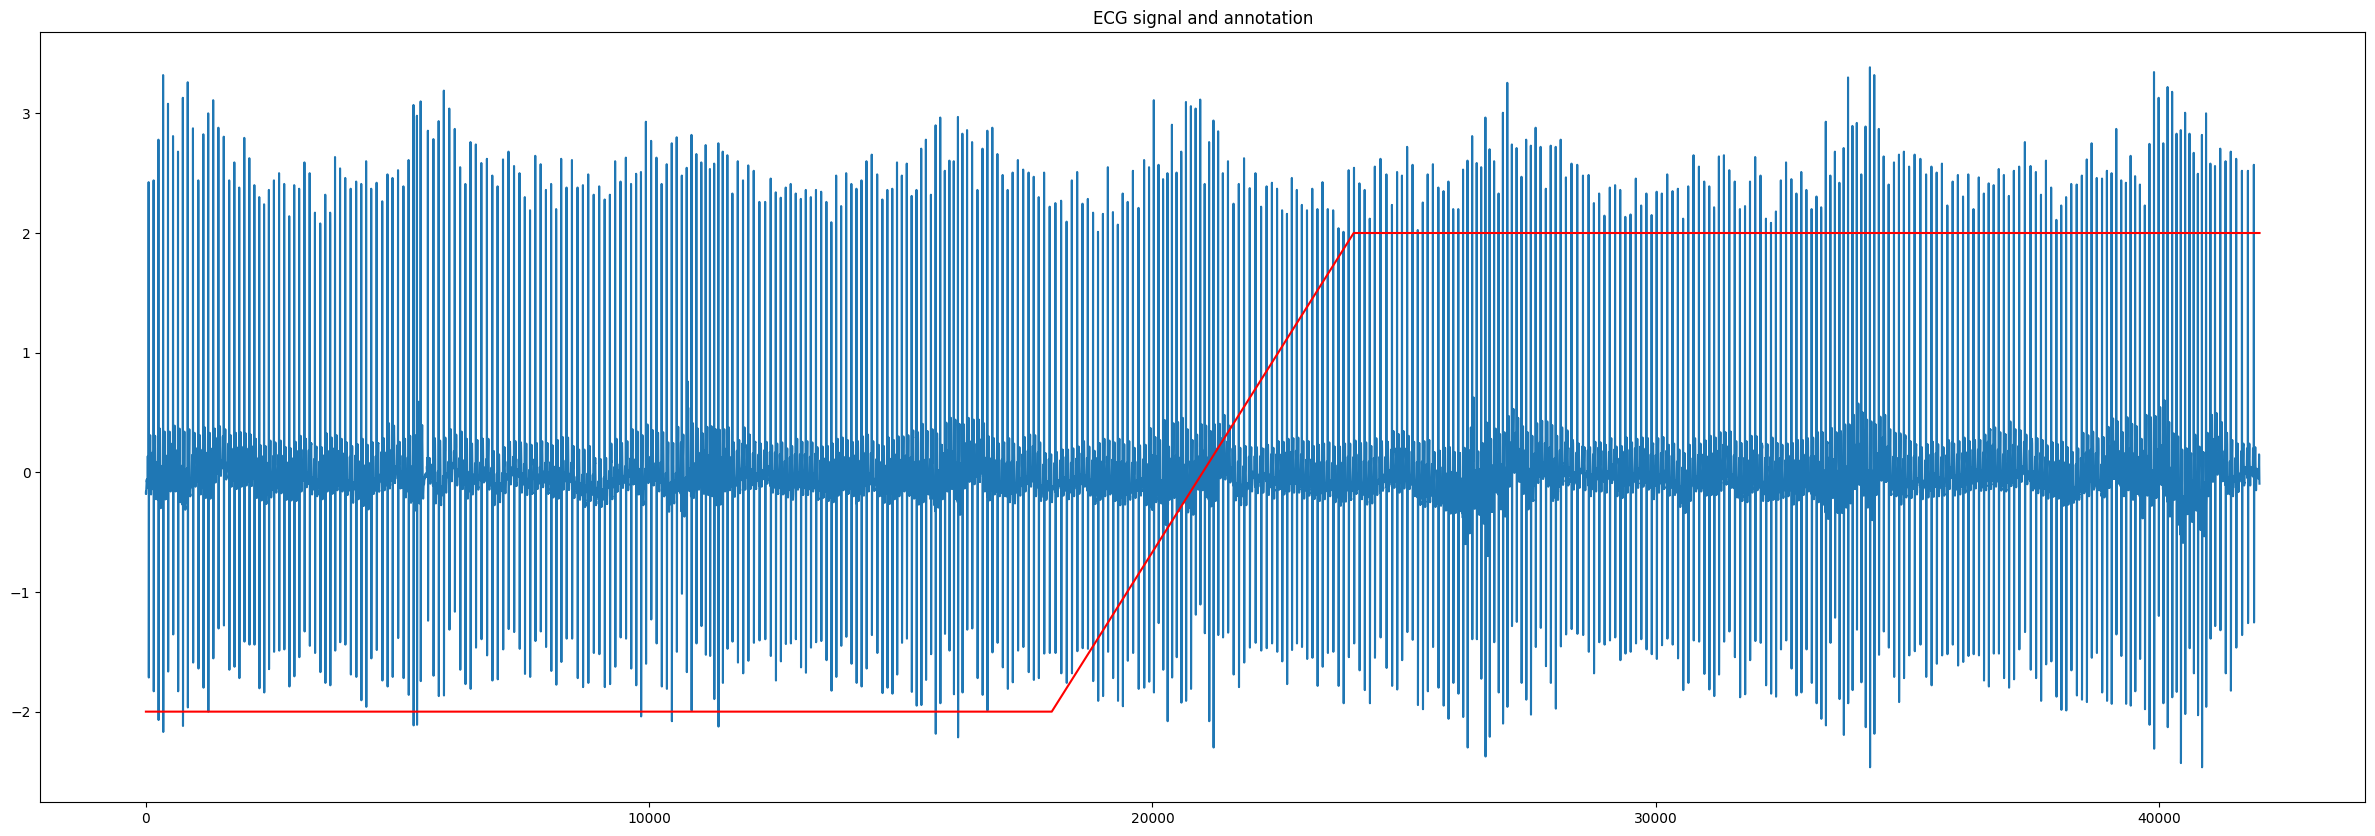

In [10]:
X, y = get_patient(5)
y = [-2 if x == 0 else 2 for x in y]

size = 7
plt.figure(figsize=(30, 10))
plt.plot(X[:size*6000:])
plt.plot(range(0, (size+1)*6000, 6000), y[:size+1:], color="r")
plt.title("ECG signal and annotation")
plt.show()

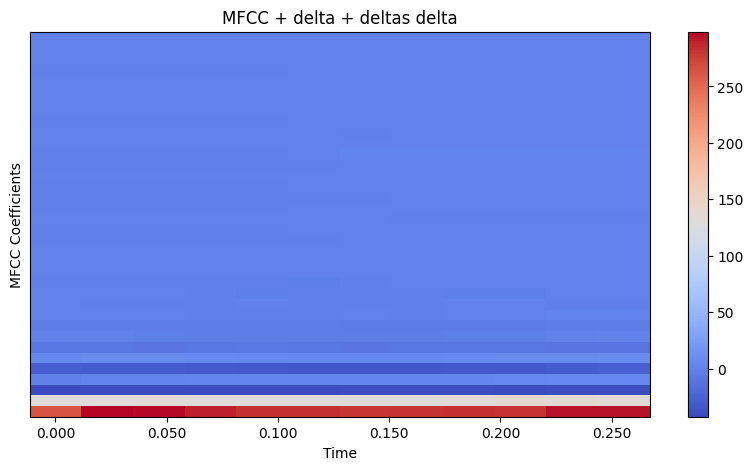

In [12]:
X = X[:6000:]
mfccs = mfcc(y=X, sr=100, n_mfcc=12)
delta1 = librosa.feature.delta(mfccs, order=1)
delta2 = librosa.feature.delta(mfccs, order=2)
mfccs = np.concatenate([mfccs, delta1, delta2])
plt.figure(figsize=(10, 5))
librosa.display.specshow(mfccs , x_axis='time')
plt.colorbar()
plt.title('MFCC + delta + deltas delta')
plt.xlabel('Time')
plt.ylabel('MFCC Coefficients')
plt.show()

In [12]:
save_path = path.join("res", "model_ECG.keras")
model = load_model(save_path)
X, y= get_patients([5])
pred = model.predict(X, verbose=False)

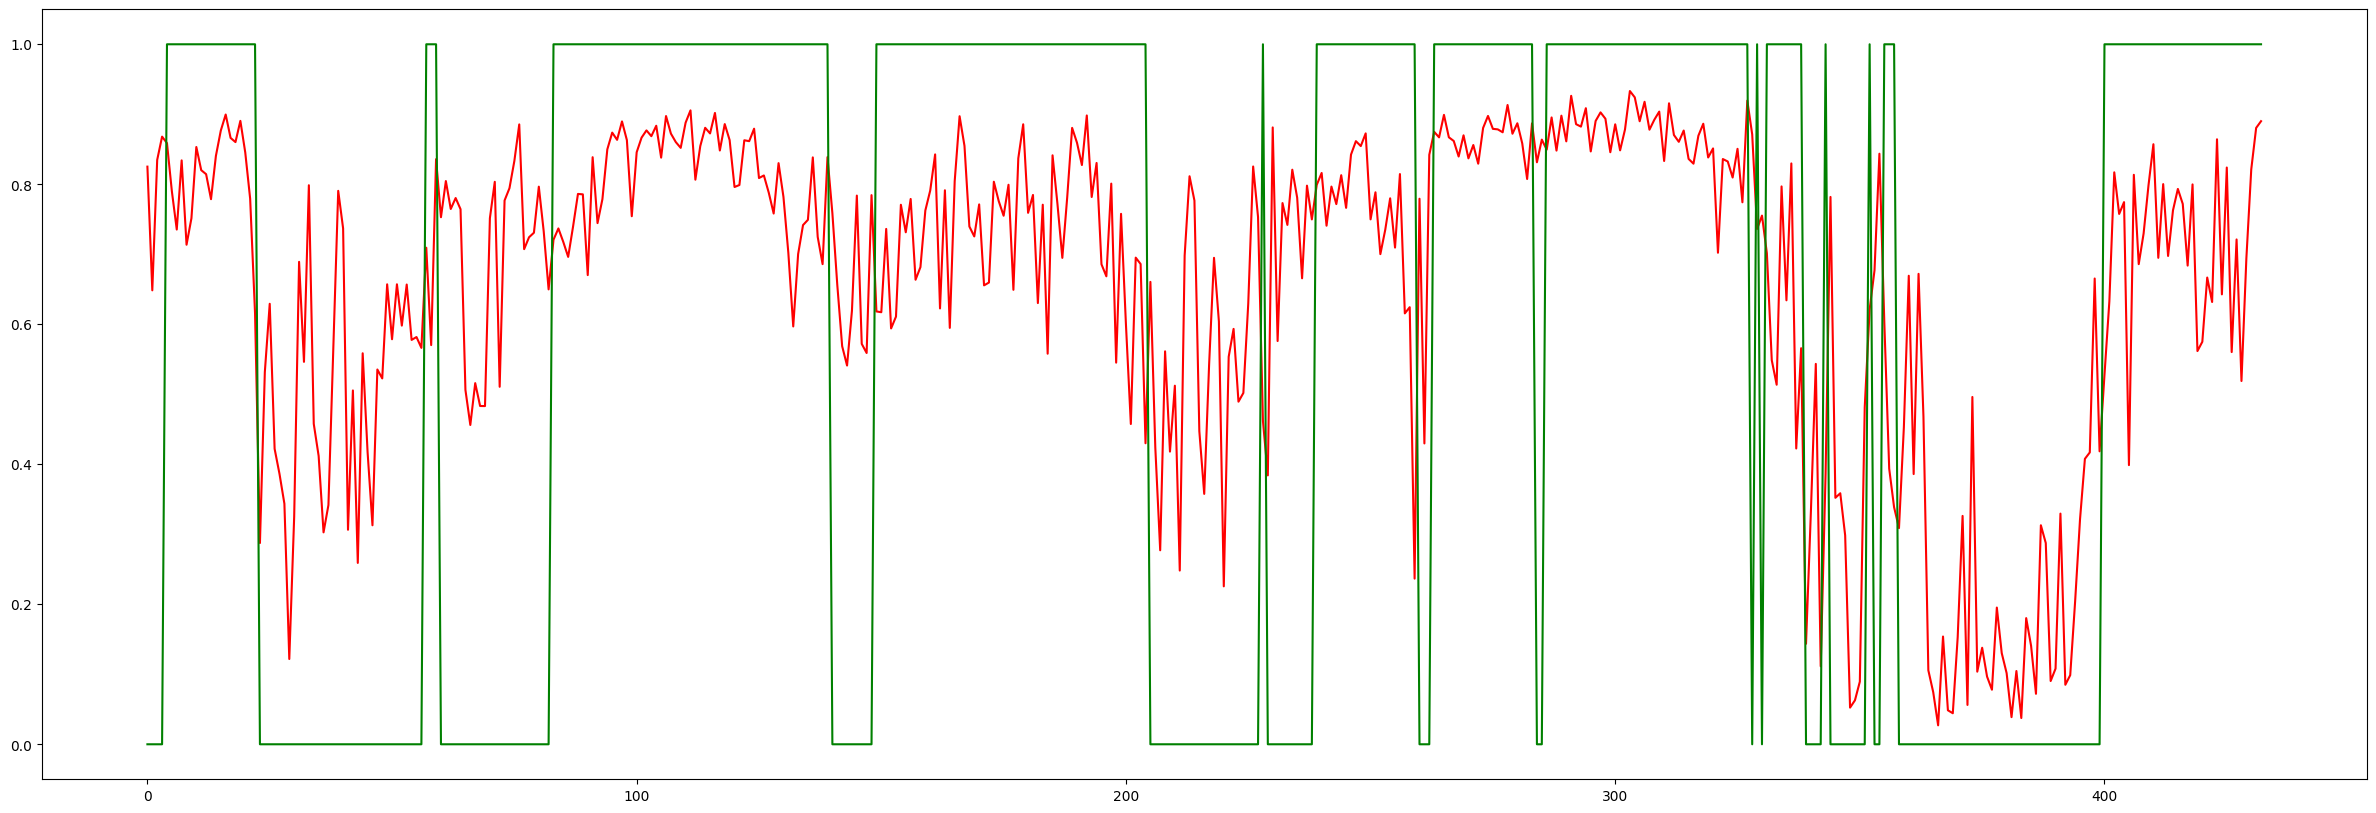

In [15]:
pred = pred.flatten()
plt.figure(figsize=(30, 10))
plt.plot(pred, color="r")
plt.plot(y, color="g")
plt.show()